In [1]:
import os
import torch
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
from collections import Counter
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [2]:
print(torch.__version__)

2.6.0+cu124


In [3]:
dataset_path = os.path.join("/kaggle/input", "weather-dataset", "dataset")
dataset_classes = os.listdir(dataset_path)
for dataset_class in dataset_classes:
    num_files = len([x for x in os.listdir(os.path.join(dataset_path, dataset_class))])
    print(f"Weather type: {dataset_class}, Num_images: {num_files}")

Weather type: hail, Num_images: 591
Weather type: rainbow, Num_images: 232
Weather type: frost, Num_images: 475
Weather type: rime, Num_images: 1160
Weather type: fogsmog, Num_images: 851
Weather type: snow, Num_images: 621
Weather type: rain, Num_images: 526
Weather type: glaze, Num_images: 639
Weather type: lightning, Num_images: 377
Weather type: sandstorm, Num_images: 692
Weather type: dew, Num_images: 698


In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(                           
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
print("Datasets constructed")

Datasets constructed


In [5]:
print(full_dataset.class_to_idx)
idx_to_class = {val: key for key, val in full_dataset.class_to_idx.items()}
print(idx_to_class)

{'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}
{0: 'dew', 1: 'fogsmog', 2: 'frost', 3: 'glaze', 4: 'hail', 5: 'lightning', 6: 'rain', 7: 'rainbow', 8: 'rime', 9: 'sandstorm', 10: 'snow'}


In [6]:
total = len(full_dataset)
train_size = int(0.7 * total)
val_size   = int(0.15 * total)
test_size  = total - train_size - val_size

train_set, val_set, test_set = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)
print(f"Splits → train: {len(train_set)}, val: {len(val_set)}, test: {len(test_set)}")

train_indices = train_set.indices     
train_labels  = [full_dataset.targets[i] for i in train_indices]

label_counts  = Counter(train_labels)
class_weights = {cls: 1.0/count for cls, count in label_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  
    replacement=True                  
)

batch_size = 64
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)
print("Oversampled train_loader ready, plus val/test loaders")

Splits → train: 4803, val: 1029, test: 1030
Oversampled train_loader ready, plus val/test loaders


In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=8, embed_dim=128):
        super().__init__()
        self.proj = nn.Conv2d(in_channels=3,
                              out_channels=embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        x = self.proj(x)              
        x = x.flatten(2)             
        x = x.transpose(1, 2).contiguous()
        return x

images = torch.rand(32, 3, 64, 64)
patch_embed = PatchEmbedding(8, 128)
output = patch_embed(images)
assert output.shape == torch.Size([32, 64, 128]), "Something wrong with patch embedding"
print("Patch embdding working")

Patch embdding working


In [8]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size, embed_dim, img_size=64):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

    def forward(self, x):
        x = self.patch_embed(x)  
        B = x.shape[0]
        cls_tokens = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_tokens, x), dim=1)          
        x = x + self.pos_embedding                    
        return x


images = torch.rand(32, 3, 64, 64)
input_embedding = InputEmbedding(8, 128)
output = input_embedding(images)
assert output.shape == torch.Size([32, 65, 128]), "Something wrong getting input encoding"
print("Input embedding successful")

Input embedding successful


In [9]:
class MLPBlock(nn.Module):
    def __init__(self, embed_dim, mlp_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x
mlp = MLPBlock(embed_dim=128, mlp_dim=512)
out = mlp(torch.randn(32, 65, 128))  # [B, N+1, D]
assert out.shape == torch.Size([32, 65, 128]), "Something wrong in MLP layer"
print("MLP block working")

MLP block working


In [10]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, mlp_dim, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.mlp = MLPBlock(embed_dim, mlp_dim, dropout=dropout)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = x.transpose(0, 1).contiguous()
        x, _ = self.mha(x, x, x)
        x = x.transpose(0, 1).contiguous()
        x = x + residual
        
        residual = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + residual
        return x
block = TransformerEncoderBlock(mlp_dim=512, embed_dim=128, num_heads=4)
x = torch.randn(32, 65, 128)  # [B, N+1, D]
out = block(x)
assert out.shape == torch.Size([32, 65, 128]), "Something wrong in Transformer block"
print("Transformer block working")

Transformer block working


In [11]:
class ViT(nn.Module):
    def __init__(self, patch_size, img_size, num_classes, embed_dim=128, depth=4, mlp_dim=512, num_heads=4):
        super().__init__()
        self.input_embedding = InputEmbedding(patch_size, embed_dim, img_size)
        encoders = []
        for _ in range(depth):
            encoders.append(TransformerEncoderBlock(mlp_dim, embed_dim, num_heads))
    
        self.encoder = nn.Sequential(*encoders)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.lin = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.input_embedding(x)
        x = self.encoder(x)
        x = self.norm3(x)
        cls_tokens = x[:, 0]
        logits = self.lin(cls_tokens) 
        return logits

model = ViT(img_size=64, patch_size=8, num_classes=10)
out = model(torch.randn(32, 3, 64, 64))
assert out.shape == torch.Size([32, 10]), "Something wrong with ViT definition"
print("ViT defined properly")

ViT defined properly


In [12]:
model = ViT(img_size=64, patch_size=8, num_classes=11)
model.to(device)
print(model)

ViT(
  (input_embedding): InputEmbedding(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 128, kernel_size=(8, 8), stride=(8, 8))
    )
  )
  (encoder): Sequential(
    (0): TransformerEncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (mlp): MLPBlock(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128,

Visualising training batch


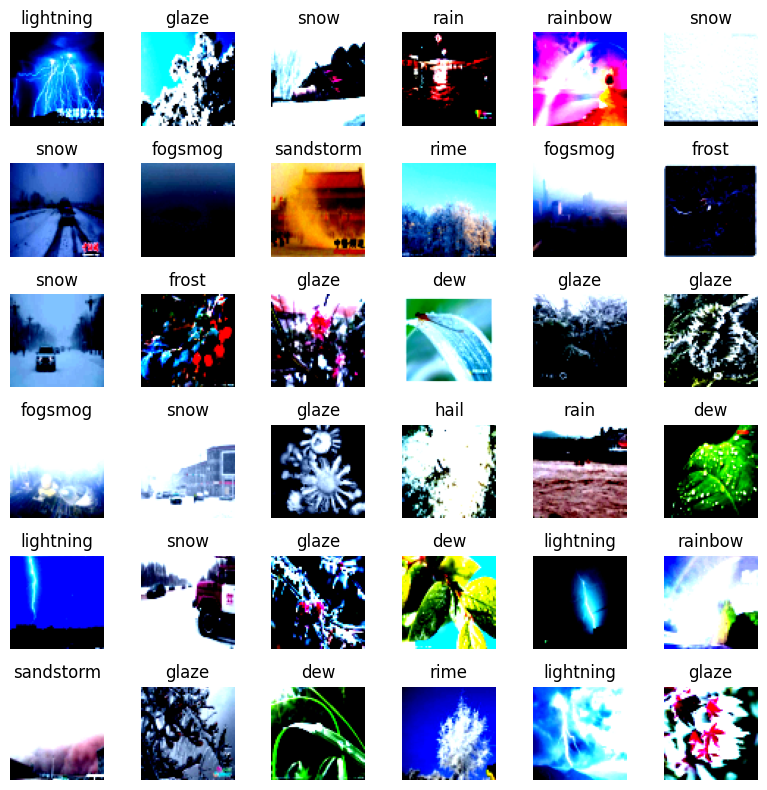

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axs = plt.subplots(6, 6, figsize=(8, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < len(images):  
        picture = torch.permute(images[i], (1, 2, 0))
        title = idx_to_class[labels[i].item()]
        ax.imshow(picture)
        ax.set_title(title)
        ax.axis('off')  
    else:
        fig.delaxes(ax) 

plt.tight_layout()  
print("Visualising training batch")
plt.show()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [15]:
NUM_EPOCHS=50
NUM_CLASSES = len(dataset_classes)
train_losses = []
val_losses = []

In [16]:
val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

for epoch in range(NUM_EPOCHS):
    model.train()

    total_train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    val_loss_sum = 0
    val_accuracy.reset() 

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss_sum += loss.item()
            val_accuracy.update(outputs, targets) 

    avg_val_loss = val_loss_sum / len(val_loader)
    epoch_val_accuracy = val_accuracy.compute() 

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    # if (epoch+1)%10 == 0:
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

torch.save(model.state_dict(), f"vit_model.pth")

Epoch 1 - Training Loss: 2.0153, Val Loss: 1.7640, Val Accuracy: 0.4451
Epoch 2 - Training Loss: 1.6888, Val Loss: 1.5136, Val Accuracy: 0.5296
Epoch 3 - Training Loss: 1.5349, Val Loss: 1.4713, Val Accuracy: 0.5345
Epoch 4 - Training Loss: 1.4257, Val Loss: 1.4070, Val Accuracy: 0.5569
Epoch 5 - Training Loss: 1.3715, Val Loss: 1.2762, Val Accuracy: 0.6054
Epoch 6 - Training Loss: 1.2964, Val Loss: 1.2637, Val Accuracy: 0.5957
Epoch 7 - Training Loss: 1.2330, Val Loss: 1.2403, Val Accuracy: 0.5986
Epoch 8 - Training Loss: 1.1963, Val Loss: 1.2692, Val Accuracy: 0.6093
Epoch 9 - Training Loss: 1.1910, Val Loss: 1.2255, Val Accuracy: 0.6161
Epoch 10 - Training Loss: 1.1514, Val Loss: 1.2049, Val Accuracy: 0.6084
Epoch 11 - Training Loss: 1.1210, Val Loss: 1.1341, Val Accuracy: 0.6385
Epoch 12 - Training Loss: 1.0870, Val Loss: 1.1892, Val Accuracy: 0.6346
Epoch 13 - Training Loss: 1.1048, Val Loss: 1.1791, Val Accuracy: 0.6239
Epoch 14 - Training Loss: 1.0844, Val Loss: 1.1623, Val Accu

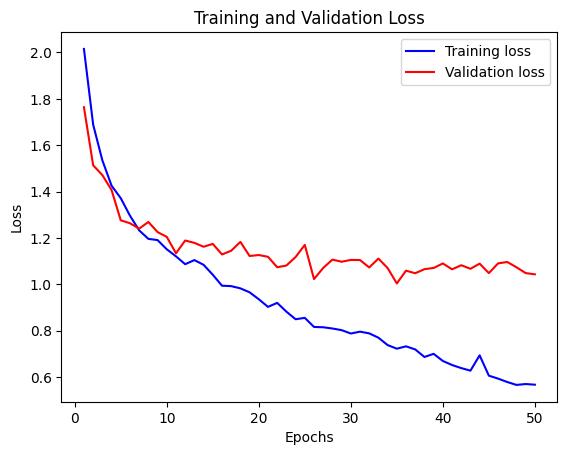

In [17]:
epochs = list(range(1, NUM_EPOCHS+1))
plt.plot(epochs, train_losses, 'b', label='Training loss') 
plt.plot(epochs, val_losses, 'r', label='Validation loss') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
test_accuracy.reset()

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_accuracy.update(outputs, targets) 

total_test_accuracy = test_accuracy.compute() 
total_test_accuracy

tensor(0.6825, device='cuda:0')